> ## Introduction to DSP

> In this seminar we will learn the basics of audio processing for **Deep Learning**.

> In the end, we will build and train neural network for spoken digit classification (aka AudioMNIST).

In [1]:
! CUDA_LAUNCH_BLOCKING=TRUE

In [2]:
import torch
# check cuda availability
torch.cuda.is_available()

True

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import torchaudio
from scipy.io import wavfile
from IPython import display
from IPython.display import clear_output
import numpy as np

In [4]:
# get torchaudio version
torchaudio.__version__
assert torch.__version__.startswith('1.12'), 'Please, install torch>=1.12'
assert torchaudio.__version__.startswith('0.12'), 'Please, install torchaudio>=0.12'

>> ### Basic Audio Preprocessing

In [5]:
# Load audio file with torchaudio

In [6]:
wav, sr = torchaudio.load('Data/19-198-0002.wav')

In [7]:
sr

16000

>>> Note that: **sr** is the sample rate encoded in Audio file.

>>> Wave is a amplitudes in the range [-1, 1] of type float32 (32 bits)

In [8]:
wav

tensor([[-0.0052, -0.0029, -0.0018,  ...,  0.0011,  0.0013,  0.0010]])

In [9]:
wav.dtype

torch.float32

In [10]:
wav.shape

torch.Size([1, 172720])

>>> Note that the shape of wav file is [1, 172720]. The first dimension means number of channels.

>>> Finally, let's see an hear that audio:

In [11]:
def visualize_audio(wav: torch.Tensor, sr: int):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)

    plt.figure(figsize=(15, 5))
    plt.plot(wav, alpha=0.5)
    plt.grid()
    plt.xlabel('Time', size=14)
    plt.ylabel('Amplitude', size=14)
    plt.show()

    display.display(display.Audio(wav, rate=sr))

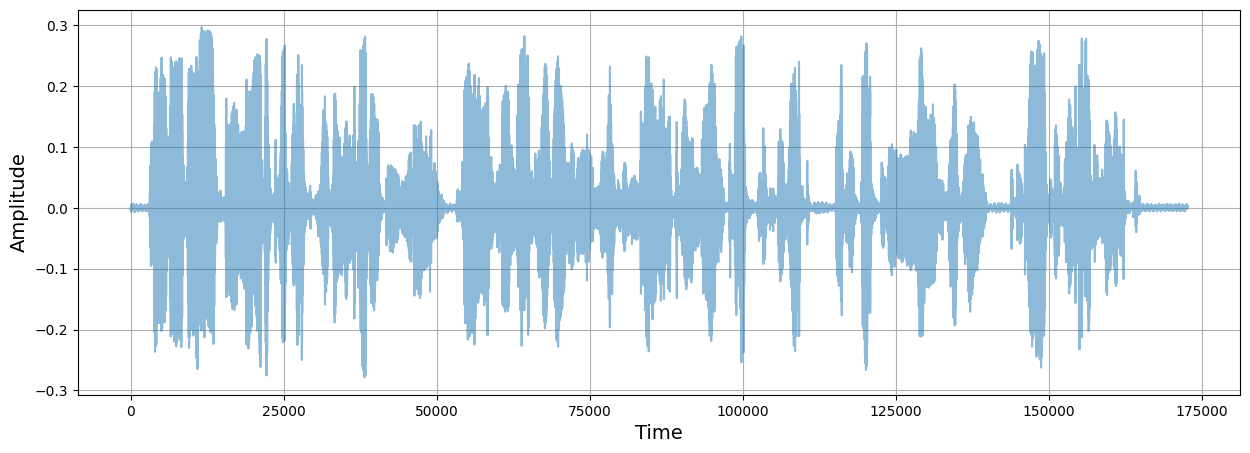

In [12]:
visualize_audio(wav=wav, sr=sr)

In [13]:
n_fft = 1024

We take the first `1024` samples and transform them. Since our signal is real, we will use `rfft` and the size of the output will be `n_fft // 2 + 1`.

In [14]:
spectrum = torch.fft.rfft(input=wav,
                            n=n_fft)

Note that spectrum have `complex` type.

In [15]:
spectrum.dtype

torch.complex64

Nextly, we would like to obtain spectrogram. In this case `abs` is complex modulus.

In [16]:
spectrogram = spectrum.abs().pow(2)

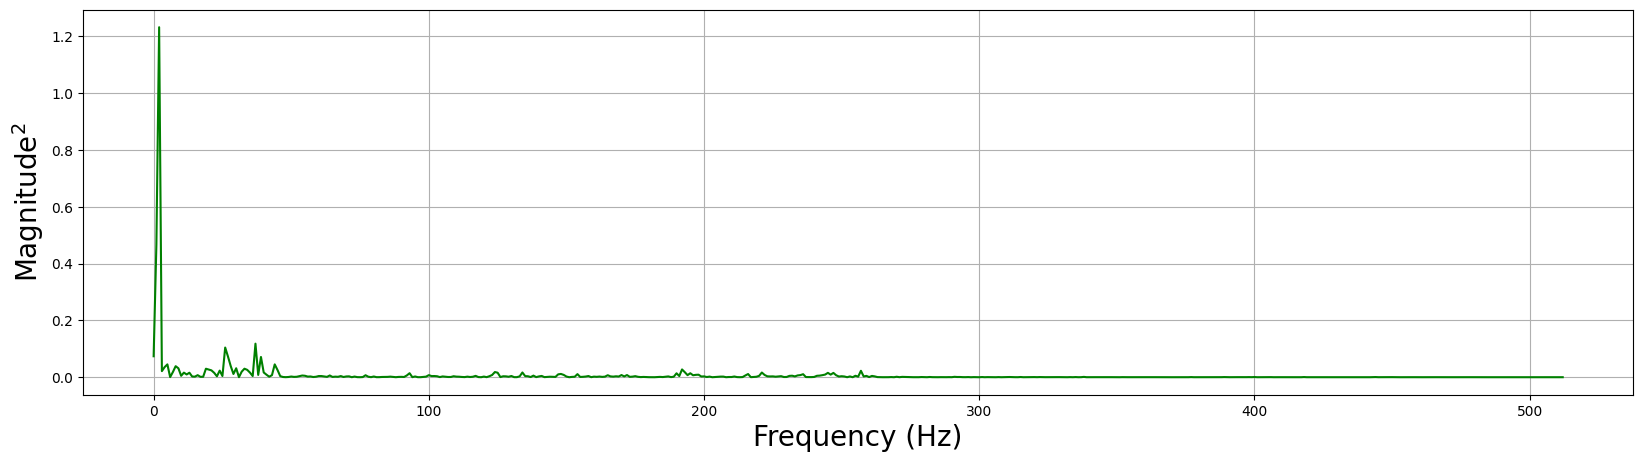

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(spectrogram.squeeze(), c='green')
plt.grid()
plt.xlabel('Frequency (Hz)', size=20)
plt.ylabel('Magnitude$^2$', size=20)
plt.show()

Of course, we don't need to forget about window function. We'll use `Hann` window function.

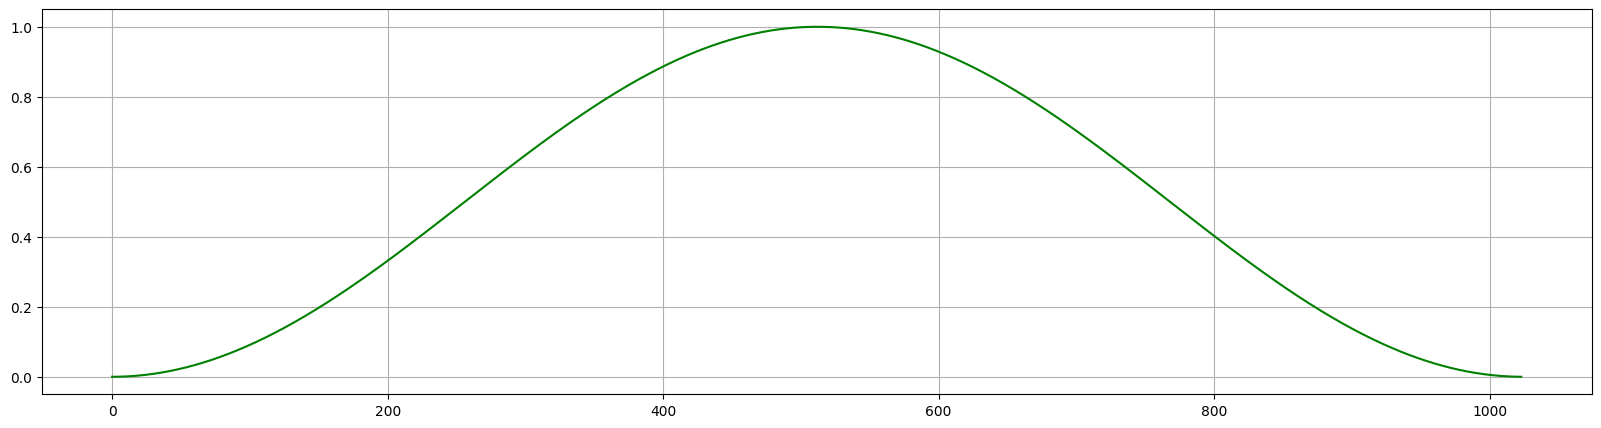

In [18]:
window_size = n_fft
window = torch.hann_window(window_size)

plt.figure(figsize=(20, 5))
plt.plot(window, c='green')
plt.grid()
plt.show()

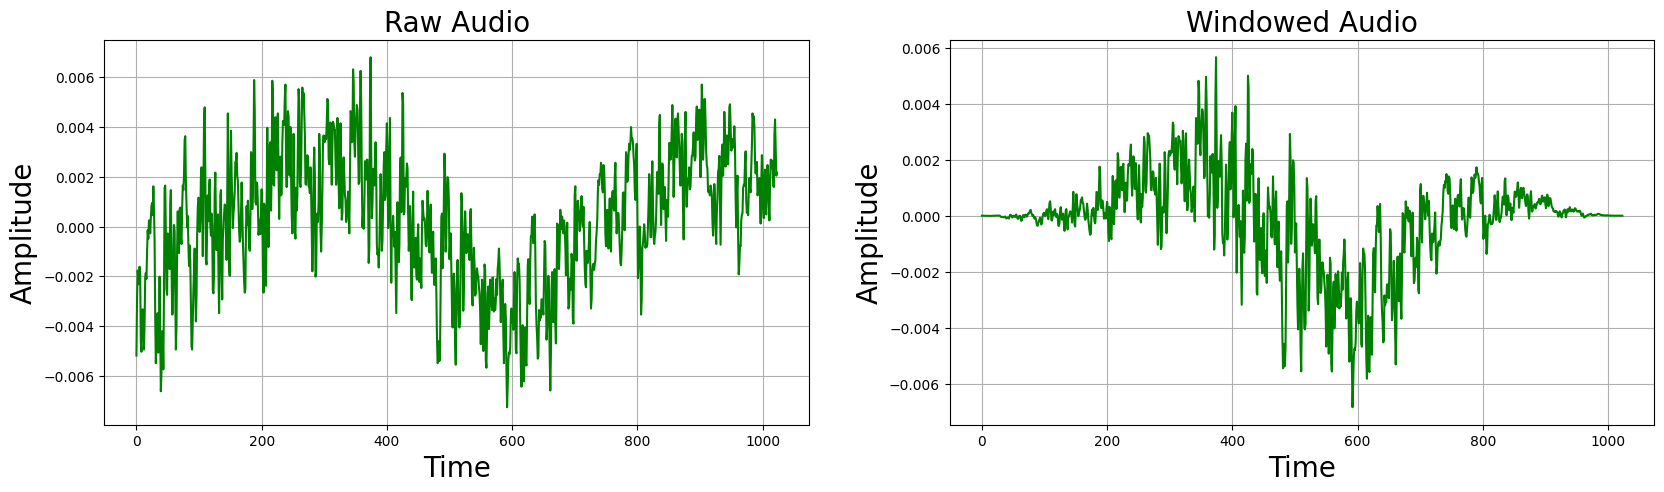

In [19]:
clipped_wav = wav[:, :window_size]
windowed_clipped_wav = window * clipped_wav

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(clipped_wav.squeeze(), c='green')
axes[0].set_title('Raw Audio', size=20)

axes[1].plot(windowed_clipped_wav.squeeze(), c='green')
axes[1].set_title('Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Time', size=20)
    axes[i].set_ylabel('Amplitude', size=20)

plt.show()

Let's put it all together and apply STFT (Short-Time Fourier Transform)

In [20]:
n_fft = 1024
window_size = n_fft
hop_size = 256
window = torch.hann_window(n_fft)

In [21]:
spectrum = torch.stft(
    input=wav,
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=window_size,
    window=window,
    # We don't want to pad input signal
    center=False,
    # Take first (n_fft // 2 + 1) frequencies
    onesided=True,

    # Apply torch.view_as_real on each window
    return_complex=False
)

In [22]:
spectrum.shape

torch.Size([1, 513, 671, 2])

In [23]:
spectrogram = spectrum.norm(dim=-1).pow(2)
spectrogram.shape

torch.Size([1, 513, 671])

The last dimension of spectrogram is time. Each timestamp is called `FRAME`. Now let's visualize the spectrogram for the whole wav.

Note that to compress the range of spectrogram values, we will apply the element wise `log`. It is classic spectrogram preprocessing.

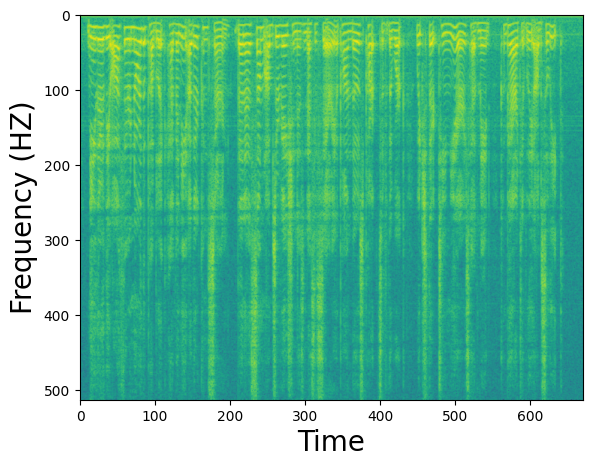

In [24]:
plt.figure(figsize=(20,5))
plt.imshow(spectrogram.squeeze().log())
plt.xlabel("Time", size=20)
plt.ylabel("Frequency (HZ)", size=20)
plt.show()

The last stage is `Mel Scale`. First of all, let's take a close look to `Mel Scale` and then apply it to our spectrogram.

To initialise `Mel Scale` we will use torchaudio.

In [25]:
mel_scaler = torchaudio.transforms.MelScale(
    n_mels=80,
    sample_rate = sr,
    n_stft=n_fft // 2 + 1
)

`Mel Scale` is nothing more than rectangle matrix. We will multiply each frame in spectrogram by `mel_scaler.fb` matrix.

In [26]:
mel_scaler.fb.shape

torch.Size([513, 80])

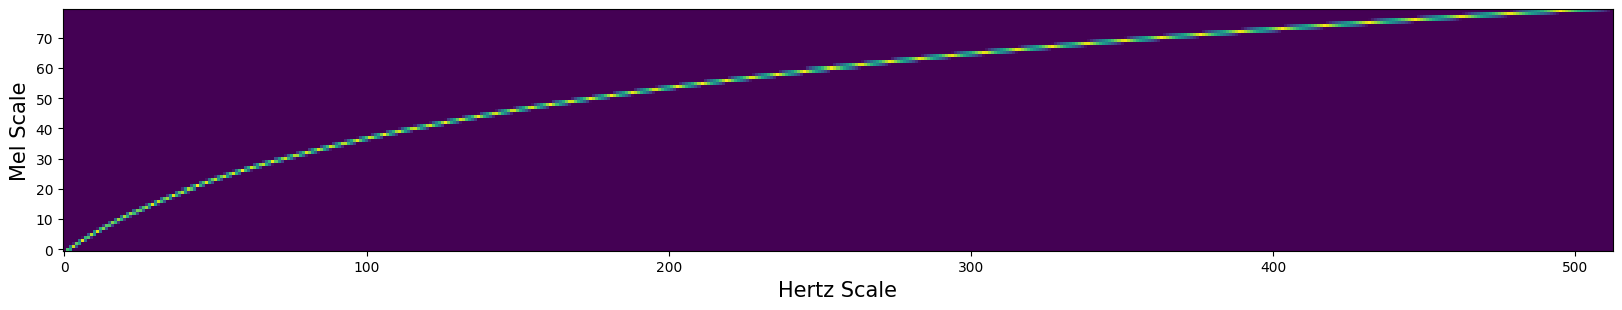

In [27]:
plt.figure(figsize=(20,5))
plt.imshow(mel_scaler.fb.T)
plt.xlabel("Hertz Scale", size=15)
plt.ylabel("Mel Scale", size=15)
plt.gca().invert_yaxis()
plt.show()

In [28]:
mel_spectrogram = mel_scaler(spectrogram)
mel_spectrogram.shape

torch.Size([1, 80, 671])

In general, we can use `MelSpectrogram` from torchaudio which combine window, stft, spectrogram and mel calculation.

In [29]:
featureizer = torchaudio.transforms.MelSpectrogram\
                    (
                        sample_rate=sr,
                        n_fft=1024,
                        win_length=1024,
                        hop_length=256,
                        n_mels=80,
                        window_fn=torch.hann_window,
                        center=False       
                    )

In [30]:
assert torch.allclose(mel_spectrogram, featureizer(wav))

> ## Audio MNIST

In [31]:
# !gdown  https://drive.google.com/uc?id=1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06 -O Data/AudioMNIST.zip
# ! unzip "Data/AudioMNIST.zip" -d "Data/"

The first part of absolutely every machine learning/deep learning problems is `data preparation`.

In [32]:
from typing import List, Tuple

import pathlib
from tqdm import tqdm
from itertools import islice
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset

In [33]:
class AudioMnistDataset(Dataset):
    SR = 16_000
    """
    Each wavfile has the following format:
        digit_speakerID_wavID.wav
    For example, 6_01_47.wav:
        6 -- the number 6 is spoken
        01 -- the number is spoken by 1 speaker
        47 -- ID of wavfile
    """

    def __init__(self, path_to_data: str) -> None:
        super().__init__()
        self.path_to_data = pathlib.Path(path_to_data)
        self.paths = list(self.path_to_data.rglob('?_*_*.wav'))

    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()

        # Load wav
        wav, sr = torchaudio.load(path_to_wav)

        # Load label
        label = int(path_to_wav.split('/')[-1].split('_')[0])

        return wav, label
    
    def __len__(self):
        return len(self.paths)

In [34]:
dataset = AudioMnistDataset('Data/AudioMNIST')

In [35]:
wav, label = dataset[100]
wav.shape, label

(torch.Size([1, 10368]), 9)

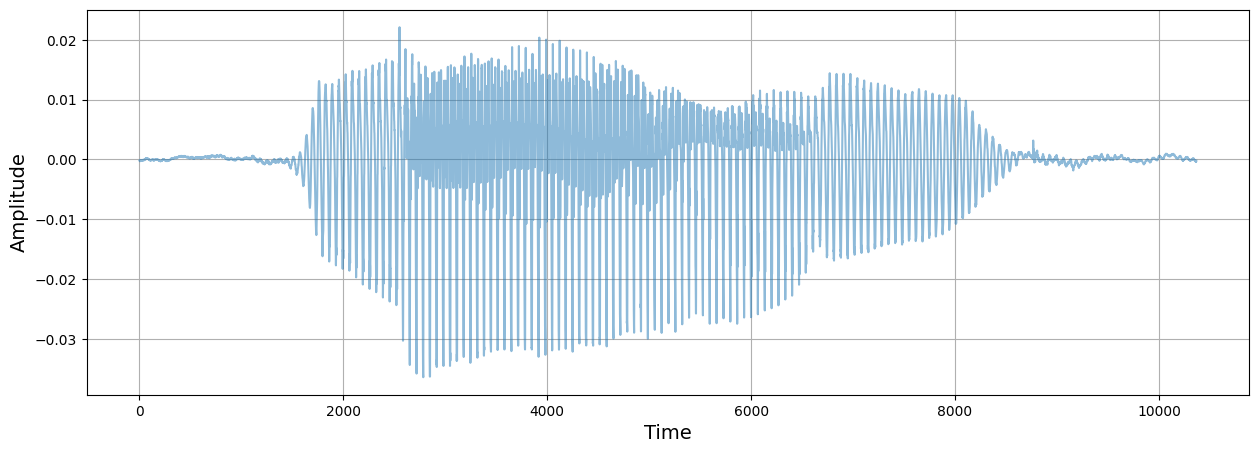

In [36]:
visualize_audio(wav, dataset.SR)

Randomly split dataset on train and validation

In [37]:
train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
validation_size = len(dataset) - train_size

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

In [38]:
assert not set(train_indexes.tolist()).intersection(set(validation_indexes.tolist()))

All Deep Learning Frameworks works with tensors (not lists of tensors). You need to somehow gather audio into a batch, but intially they are of different lengths.

We will apply a simple ZERO PADDING.

In [39]:
class Collator:
    def __call__(self, batch: List[Tuple[torch.Tensor, int]]):
        lengths = []
        wavs, labels = zip(*batch)
        
        for wav in wavs:
            lengths.append(wav.size(-1))
        
        # -----------------------------------------------------------------------
        max_length = max(lengths)
        # here we should pad wvas to one length, cause we need pass it to network
        batch_wavs = torch.zeros(len(batch), max_length)
        for i, wav in enumerate(wavs):
            batch_wavs[i, :lengths[i]] = wav
        # -----------------------------------------------------------------------
        labels = torch.tensor(labels).long()
        lengths = torch.tensor(lengths).long()
        
        return {
            'wav': batch_wavs,
            'label': labels,
            'length': lengths,
        }

In [40]:
batch_size = 2

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True, 
    collate_fn=Collator(),
    num_workers=2, 
    pin_memory=True
)


validation_dataloader = DataLoader(
    validation_dataset, 
    batch_size=batch_size,
    collate_fn=Collator(),
    num_workers=2, 
    pin_memory=True
)

In [41]:
for i, batch in enumerate(tqdm(train_dataloader)):
    print(batch['wav'].shape)

    if i == 0:
        break
    


  0%|          | 0/13500 [00:01<?, ?it/s]

torch.Size([2, 11437])


In [42]:
class Featurizer(nn.Module):
    
    def __init__(self):
        super(Featurizer, self).__init__()
        
        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=16_000,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=64,
            center=True
        )
        
    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()
        
        if length is not None:
            length = torch.div((length - self.featurizer.win_length), self.featurizer.hop_length, \
                                 rounding_mode='floor')
            # We add `4` because in MelSpectrogram center==True
            length += 1 + 4
            
            return mel_spectrogram, length
        
        return mel_spectrogram

In [43]:
featurizer = Featurizer()

for i, batch in enumerate(tqdm(train_dataloader)):
    wav = batch['wav']
    length = batch['length']
    label = batch['label']

    mel, mel_length = featurizer(wav, length)

    break   
length.shape

  0%|          | 0/13500 [00:00<?, ?it/s]


torch.Size([2])

In [44]:
class Model(nn.Module):

    def __init__(self, input_dim, hidden_size) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size=input_dim,
                           hidden_size=hidden_size,
                           num_layers=1,
                           batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 10)

    def forward(self, x, length=None):
        # input: [batchSize, hiddenSize, seqLen]
        output, _ = self.rnn(x.transpose(-1, -2))
        # output: [batchSize, seqLen, hiddenSize]

        # Now we want to take the last hidden state of each instance in batch
        # BUT we don't want to take `padding` hidden state
        # We will use `torch.gather` and `length` to do that   

        # First we need to create a tensor with indexes of last hidden state
        # For example, if we have 3 instances in batch with lengths [2, 3, 1]
        last_hidden = torch.gather(
            input=output,
            dim=1,
            index=length.sub(1).view(-1, 1, 1).expand(-1, 1, self.hidden_size)
        )
        
        logits = self.fc(last_hidden.squeeze(dim=1))
        
        return logits

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Model(input_dim=64, hidden_size=128).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [46]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [47]:
storage = defaultdict(list)
num_epoch = 10

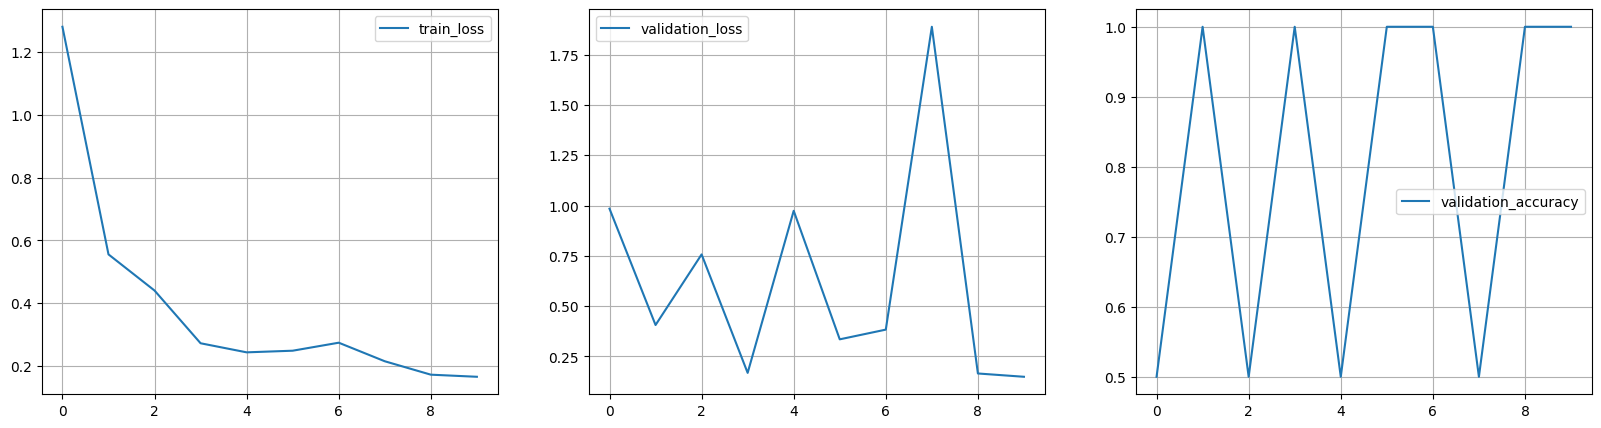

In [48]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        mel, mel_length = featurizer(wav, length)
        output = model(mel, mel_length)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(validation_dataloader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)

            loss = criterion(output, label)
        
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    display.clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()
    

In [49]:
def inference(dataloader, take_n=10):
    """
    Display wav and results of NN
    """
    batch = next(iter(dataloader))
    wav = batch['wav'].to(device)[:take_n]
    length = batch['length'].to(device)[:take_n]
    label = batch['label'].to(device)[:take_n]

    mel_inputs, mel_length = featurizer(wav, length)
    output = model(mel_inputs, mel_length)
    classes = output.argmax(dim=-1)

    for i in range(take_n):
        display.display(display.Audio(wav[i].cpu().numpy(), rate=16_000))
        print("Predict: ", classes[i])
        print("Label: ", label[i])

In [50]:
inference(validation_dataloader, take_n=2)

Predict:  tensor(1, device='cuda:0')
Label:  tensor(1, device='cuda:0')


Predict:  tensor(7, device='cuda:0')
Label:  tensor(7, device='cuda:0')
